# NYU PUI HOMEWORK 12 - Part 2 
## Economic Development Clustering by ZipCode
December 13, 2018

__Author__ = zem232

### Goal: Examine cluster and trends in NYC Business Data.

Using Sklearn's K-Means clustering and Agglomerative clustering algorithms.

#### Establishment Definition (US Census Factfinder)

"An establishment is a single physical location at which business is conducted or services or industrial operations are performed. It is not necessarily identical with a company or enterprise, which may consist of one or more establishments. When two or more activities are carried on at a single location under a single ownership, all activities generally are grouped together as a single establishment. The entire establishment is classified on the basis of its major activity and all data are included in that classification. 

...

Establishment counts represent the number of locations with paid employees any time during the year. This series excludes governmental establishments except for wholesale liquor establishments (NAICS 4248), retail liquor stores (NAICS 44531), Federally-chartered savings institutions (NAICS 522120), Federally-chartered credit unions (NAICS 522130), and hospitals (NAICS 622). For a full list of definitions see CBP Definitions"

In [331]:
import pandas as pd
import numpy as np
import zipfile
import os
import urllib
import geopandas as gp
from fiona.crs import from_epsg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

%pylab inline

np.random.seed(666)

Populating the interactive namespace from numpy and matplotlib


/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Download Data

In [90]:
## Downloading NYC Zip Code Shapefile, obtained from NYC Open Data
! rm $PUIDATA/*ZIP_CODE_*
! rm *ZIP_CODE_*
url = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'
urllib.request.urlretrieve(url,'ZIP_CODE_040114.zip')
! unzip 'ZIP_CODE_040114.zip' -d $PUIDATA

Archive:  ZIP_CODE_040114.zip
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/ZIP_CODE_040114.shx  
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/ZIP_CODE_040114.dbf  
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/ZIP_CODE_040114.prj  
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/ZIP_CODE_040114.sbn  
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/ZIP_CODE_040114.sbx  
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/ZIP_CODE_040114.shp  
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/ZIP_CODE_040114.shp.xml  


In [3]:
nyczipsshp = gp.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")

In [4]:
## Downloading the US Census Bureau Zip Code Business Statistics by year
## Available at the following website link if the GitHub page is down:
## https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=BP_2014_00CZ1&prodType=table

## I'm lazy and don't want to manually type each year
! rm $PUIDATA/*totals.txt*
zips = ['00','01','02','03','04','05','06','07','08','09']
a=[]
for x in range(10,15):
    a.append(str(x))
for x in range(94,100):
    a.append(str(x))
zips = zips + a

## Downloading the zip files available on Federica's GitHub, and unzipping the contents in Puidata
for i in range(len(zips)):
    url = 'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp'+zips[i]+'totals.zip'
    filename = 'zips'
    urllib.request.urlretrieve(url,'zipfile.zip')
    ! unzip 'zipfile.zip' -d $PUIDATA
! rm 'zipfile.zip'  
    

Archive:  zipfile.zip
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/zbp00totals.txt  
Archive:  zipfile.zip
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/zbp01totals.txt  
Archive:  zipfile.zip
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/zbp02totals.txt  
Archive:  zipfile.zip
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/zbp03totals.txt  
Archive:  zipfile.zip
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/zbp04totals.txt  
Archive:  zipfile.zip
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/zbp05totals.txt  
Archive:  zipfile.zip
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/zbp06totals.txt  
Archive:  zipfile.zip
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/zbp07totals.txt  
Archive:  zipfile.zip
  inflating: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/zbp08totals.txt  
Archive:  zipfile.zip
  inflating: /U

### Data Cleaning & Wrangling

In [84]:
## Creating a pandas dataframe by reading in the first year's file
## Then selecting only the number of establishments & Zipcode columns
## Renaming the establishments column to the year, so the year isn't lost
csb = pd.read_csv(os.getenv('PUIDATA')+'/zbp'+zips[0]+'totals.txt')
csb.drop(['NAME','EMPFLAG', 'EMP', 'QP1', 'AP'], axis=1, inplace=True)
csb.rename(columns={'EST':'%s'%(zips[0])},inplace=True)

## Creating temporary dataframes for all other years & merging with the csb dataframe
## Some files have either all upper case or all lower case for column names
for i in range(1,len(zips)):
    df = pd.read_csv(os.getenv('PUIDATA')+'/zbp'+zips[i]+'totals.txt')
    if 'est' in df.columns:
        dropcols = [c for c in df.columns.values if c != 'est' and c != 'zip']
        df.drop(dropcols, axis=1, inplace=True)
        df.rename(columns={'est':zips[i], 'zip':'ZIP'},inplace=True)
    elif 'EST' in df.columns:
        dropcols = [c for c in df.columns.values if c != 'EST' and c != 'ZIP']
        df.drop(dropcols, axis=1, inplace=True)
        df.rename(columns={'EST':zips[i]},inplace=True)
    else:
        print('Census Bureau dataframe for '+zips[i]+' has no est or EST column!')
    csb = csb.merge(df, on='ZIP',how='outer')

## Cleaning up csb dataframe: re-naming columns & sorting by the actual year
## Converting the ZIP column to string & filling in zeros.
## Merging with the NYC Zip Code shapefile

year20__ = [(x) for x in csb.columns if x.startswith ('0') or x.startswith ('1')]
year19__ = [(x) for x in csb.columns if x.startswith ('9')]
for y in year20__:
    csb.rename(columns={y:'20%s'%(y)},inplace=True)
for y in year19__:
    csb.rename(columns={y:'19%s'%(y)},inplace=True)
csb.sort_index(axis=1,inplace=True)
csb['ZIP'] = csb.ZIP.astype(str).str.zfill(5)
csb = nyczipsshp.merge(csb, left_on='ZIPCODE', right_on='ZIP',how='left')

In [85]:
## Cleaning the csb dataframe (dropping columns & NaN)
csb.index = csb.ZIPCODE
csb.drop(['ZIPCODE','BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE',
       'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN','geometry','ZIP'],
        axis=1, inplace=True)
cleancsb = csb.dropna(axis=0, how='any')

ZIPCODES: 248 
POLYGONS: 263 
The difference is due to island polygons disjointed from the mainland.
number of NYC zip codes: 263


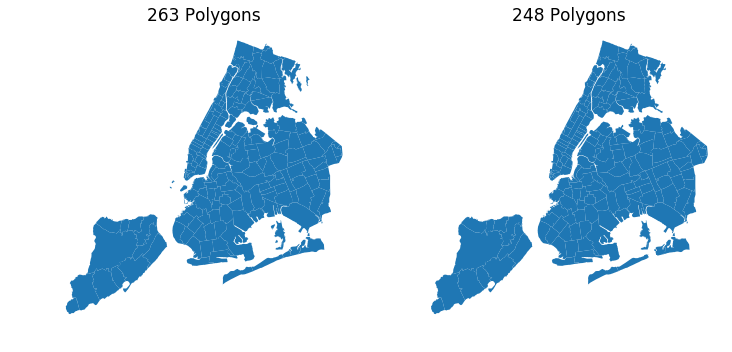

In [220]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,12))
ax1.set_axis_off()
ax2.set_axis_off()
ax1.set_title('%i Polygons'%(len(nyczipsshp.ZIPCODE)),size=17)
nyczipsshp.plot(ax=ax1)
nyczipsshp.drop_duplicates("ZIPCODE").plot(ax=ax2)
ax2.set_title('%i Polygons'%(len(np.unique(nyczipsshp.ZIPCODE))), size=17)
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "\nPOLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "\nThe difference is due to island polygons disjointed from the mainland.")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

In [87]:
## Normalizing the dataframe for each Zip Code
## This allows us to provide adequate comparisons between Zipcodes
vals = ((cleancsb.T - cleancsb.mean(1)) / cleancsb.std(1)).T
print(vals.mean(axis=1).shape)
vals.std(axis=1).shape
vals.head()

(243,)


,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,-0.988538,0.087870,-0.117160,...,0.292900,0.190385,0.395415,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853
11213,-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,-0.636364,-0.150580,0.060232,...,-0.058923,0.023569,-0.058923,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875
11212,-1.077974,-1.210216,-1.114040,-0.813490,-0.909666,-0.645182,-0.897644,-0.813490,-0.212389,-0.164301,...,-0.092169,-0.296543,-0.092169,0.088161,0.629152,1.254297,1.422605,1.518781,1.639001,1.891464
11225,-1.223282,-1.159696,-1.149098,-0.915948,-0.852361,-0.926545,-0.841764,-0.788775,-0.184704,-0.089324,...,-0.057531,0.027251,0.186217,0.249804,0.493552,0.885668,1.065830,1.341371,1.871258,2.115007
11218,-1.474935,-1.336988,-1.180649,-1.061095,-0.863371,-0.720826,-0.665648,-0.578281,-0.357567,-0.270200,...,0.120649,0.116050,0.327569,0.419533,0.695427,0.773596,0.998909,1.375964,1.753018,1.978331


Text(0.5,1,'NYC Establishments Development by Zip Code')

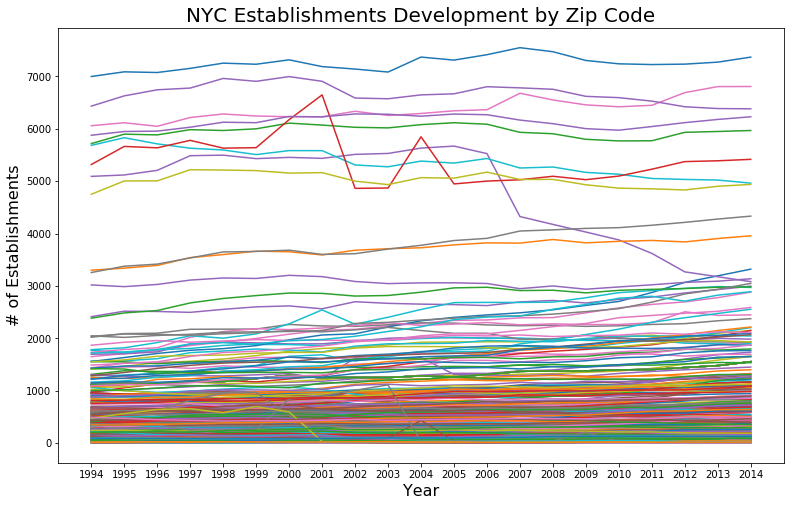

In [161]:
plt.figure(figsize=(13, 8))
x = cleancsb.columns
for z in cleancsb.index:
    y = cleancsb[cleancsb.index == z].values.T
    plt.plot(x,y)
    
plt.xlabel('Year', fontsize = 16)
plt.ylabel('# of Establishments', fontsize = 16)
plt.title('NYC Establishments Development by Zip Code', fontsize = 20)

**Figure 1** The figure plots the timeseries of the number of establishments in NYC by Zip code. Some zip codes have a higher number of registered businesses compared to other zip codes (as expected), and there seems to be a general increasing trend in registered number of establishments (with some exceptions). 

Text(0.5,1,'NYC Establishments Development by Zip Code')

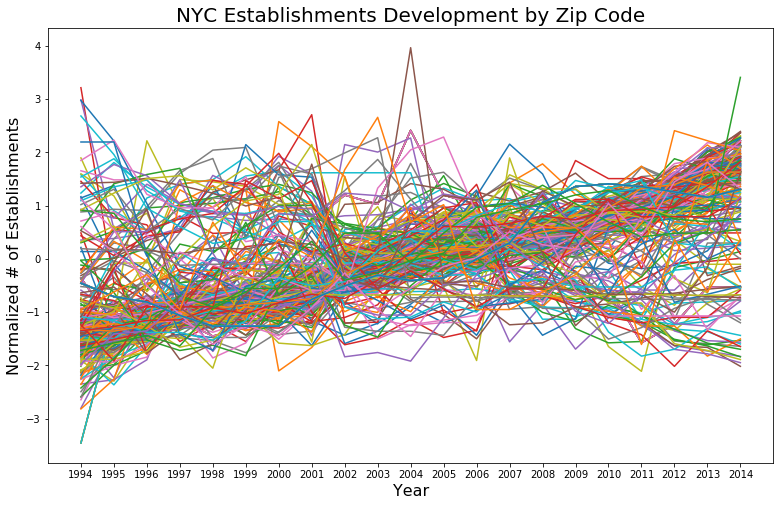

In [162]:
plt.figure(figsize=(13, 8))
x = vals.columns
for z in vals.index:
    y = vals[vals.index == z].values.T
    plt.plot(x,y)
    
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Normalized # of Establishments', fontsize = 16)
plt.title('NYC Establishments Development by Zip Code', fontsize = 20)

**Figure 2** Plotting the timeseries of number of establishments in NYC, normalized across each Zip code. This is quite difficult to interpret, except one key point taken from this plot is that there is no general trend that applies to each Zip Code.

### K-Means Clustering

Number of zip codes in g line cluster: 187
Number of zip codes in c line cluster: 36
Number of zip codes in pink line cluster: 20
(g: green ; c: cyan)


Text(0.5,1,'NYC Zip Code Establishment Clusters (K-Means, k=3)')

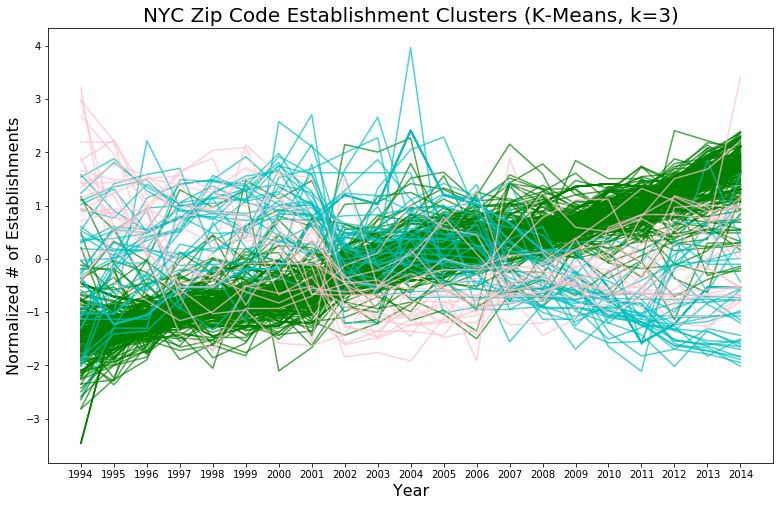

In [341]:
nc = 3
km = KMeans(n_clusters=nc, random_state=444)
labels = km.fit(vals).labels_
cluster = km.fit_predict(vals)
colors = ['g','c','pink']
plt.figure(figsize=(13, 8))
x = vals.columns
for u in unique(labels):
    for z in vals[cluster==u].index:
        y = vals[vals.index == z].values.T
        plt.plot(x,y, color=colors[u], alpha = 0.7)
    print('Number of zip codes in %s line cluster: %i'%(colors[u],len(vals[cluster==u])))
print('(g: green ; c: cyan)')

plt.xlabel('Year', fontsize = 16)
plt.ylabel('Normalized # of Establishments', fontsize = 16)
plt.title('NYC Zip Code Establishment Clusters (K-Means, k=3)', fontsize = 20)


**Figure 3:** The k-means clustering method with 3 clusters seems to have grouped each zip code by trend. The green cluster, with the highest count of zip codes (187) shows a general increasing trend over time. The cyan cluster shows a general peak in the middle of the time series at around year 2004, and the pink line indicates the opposite trend with a nadir around year 2004.

Number of zip codes in g line cluster: 133
Number of zip codes in c line cluster: 23
Number of zip codes in y line cluster: 21
Number of zip codes in b line cluster: 50
Number of zip codes in pink line cluster: 16
(g: green ; c: cyan ; y: yellow ; b: blue)


Text(0.5,1,'NYC Zip Code Establishment Clusters (K-Means, k=5)')

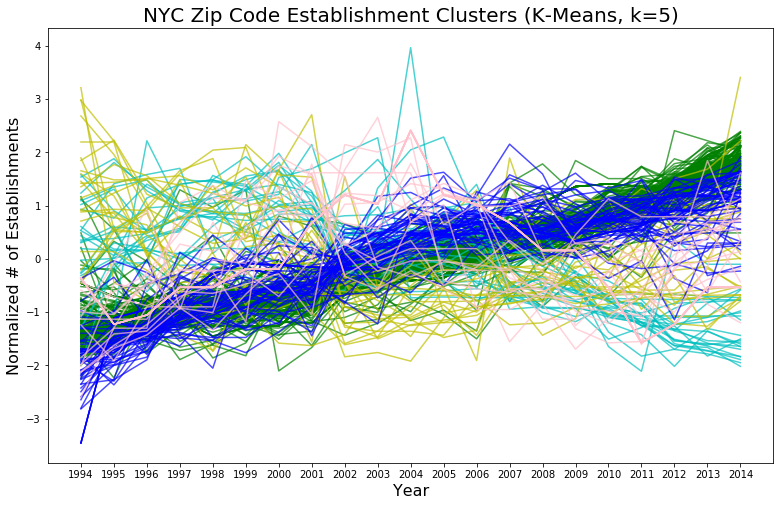

In [342]:
nc = 5
km = KMeans(n_clusters=nc, random_state=444)
labels = km.fit(vals).labels_
cluster = km.fit_predict(vals)
colors = ['g','c','y','b','pink']
plt.figure(figsize=(13, 8))
x = vals.columns
for u in unique(labels):
    for z in vals[cluster==u].index:
        y = vals[vals.index == z].values.T
        plt.plot(x,y, color=colors[u], alpha = 0.7)
    print('Number of zip codes in %s line cluster: %i'%(colors[u],len(vals[cluster==u])))
print('(g: green ; c: cyan ; y: yellow ; b: blue)')

plt.xlabel('Year', fontsize = 16)
plt.ylabel('Normalized # of Establishments', fontsize = 16)
plt.title('NYC Zip Code Establishment Clusters (K-Means, k=5)', fontsize = 20)


**Figure 4:** The k-means clustering method with 5 clusters. The green & blue cluster shows a general increasing trend over time, while the other clusters are quite difficult to interpret. 

Number of zip codes in g line cluster: 178
Number of zip codes in c line cluster: 31
Number of zip codes in y line cluster: 16
Number of zip codes in b line cluster: 18
(g: green ; c: cyan ; y: yellow ; b: blue)


Text(0.5,1,'NYC Zip Code Establishment Clusters (K-Means, k=4)')

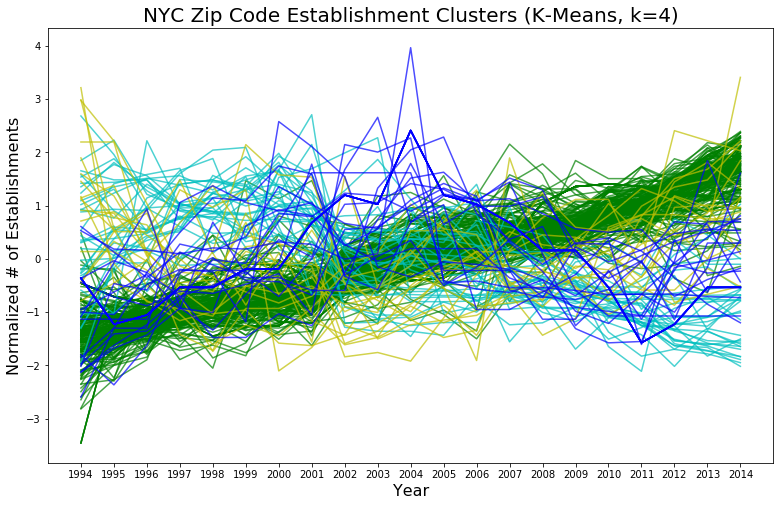

In [343]:
nc = 4
km = KMeans(n_clusters=nc, random_state=444)
labels = km.fit(vals).labels_
cluster = km.fit_predict(vals)
colors = ['g','c','y','b']
plt.figure(figsize=(13, 8))
x = vals.columns
for u in unique(labels):
    for z in vals[cluster==u].index:
        y = vals[vals.index == z].values.T
        plt.plot(x,y, color=colors[u], alpha = 0.7)
    print('Number of zip codes in %s line cluster: %i'%(colors[u],len(vals[cluster==u])))
print('(g: green ; c: cyan ; y: yellow ; b: blue)')

plt.xlabel('Year', fontsize = 16)
plt.ylabel('Normalized # of Establishments', fontsize = 16)
plt.title('NYC Zip Code Establishment Clusters (K-Means, k=4)', fontsize = 20)


**Figure 5:** The k-means clustering method plotted with 4 clusters. The green cluster, with the highest count of zip codes (178) shows a general increasing trend over time, while the cyan cluster shows a general decreasing trend over time. The blue cluster shows a general peak in the middle of the time series at around year 2004, and the yellow line indicates the opposite trend with a nadir around year 2004. Comparing Figures 3 through 5, I believe that these 4 clusters sufficiently identify the four main trends in NYC establishment development.

In [315]:
unique(labels)

array([0, 1, 2, 3], dtype=int32)

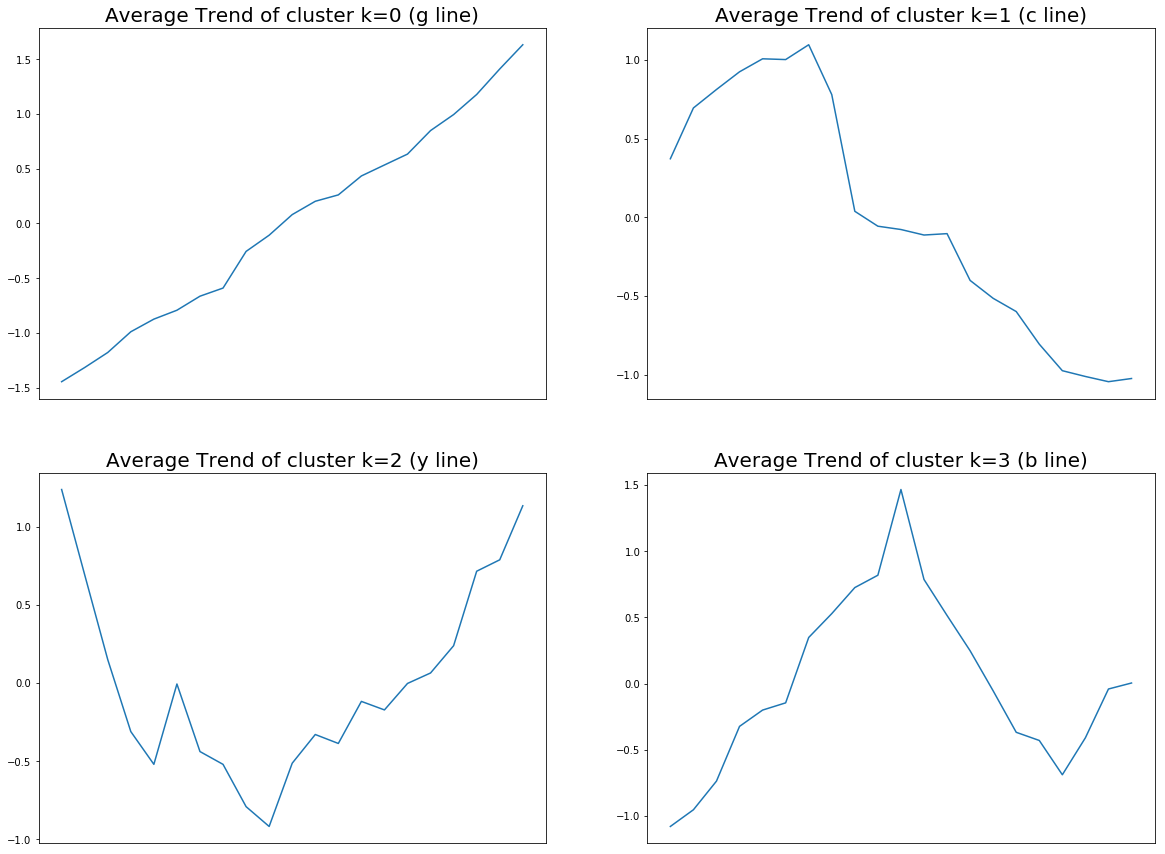

In [350]:
fig=plt.figure(figsize=(20,15))
for u in unique(labels):
    plt.subplot(2,2,u+1)
    plt.plot(vals[cluster== u].mean(axis=0), '-')
    plt.xticks([])
    plt.title('Average Trend of cluster k=%s (%s line)'%(u,colors[u]),size=20)

**Figure 4:** The average trend of each zip code cluster (plotted in Figure 3) are shown in these quadrant plots, plotted for the same period of time as in Figure 3 (1994 - 2014). The average trend is more clean and is consistent with the general trend as illustrated by each individual zip code plot in Figure 3. 

In [317]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 1, 0, 0, 3, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 3, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 3, 1, 1, 2, 2, 1, 0, 1, 0, 1, 0, 0, 0, 3, 1, 2,
       2, 1, 1, 3, 0, 1, 2, 1, 0, 1, 1, 0, 2, 1, 0, 1, 2, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 0, 2, 0, 2, 3, 3, 1, 1, 0, 0, 0, 0, 3, 3, 2, 0, 3,
       0], dtype=int32)

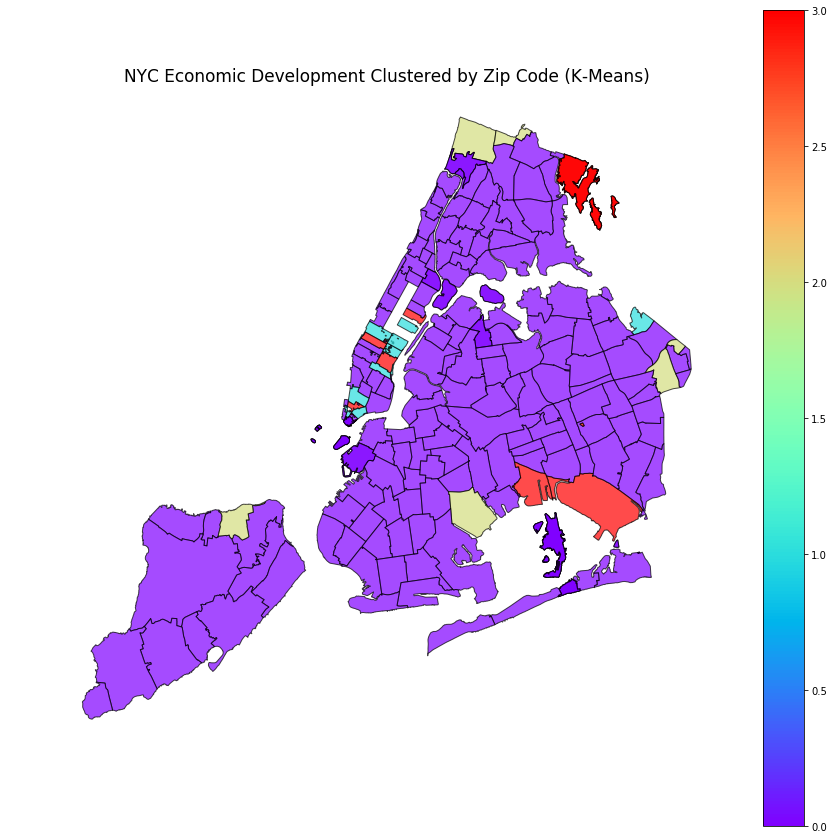

In [354]:
nyczipsshp.crs = from_epsg(4326)
nyczipsshp.crs
df = pd.DataFrame(index=cleancsb.index, data=labels, columns={'labels'})
merged = nyczipsshp.merge(df, on='ZIPCODE')
f, ax = plt.subplots(1,figsize=(15,15))
ax.set_axis_off()
ax.set_title('NYC Economic Development Clustered by Zip Code (K-Means)',size=17)
merged.plot(ax=ax, column='labels', cmap='rainbow', k=3, edgecolor='k',legend=True, alpha=0.7)


**Figure 6:** Choropleth plot of zip codes, clustered by trends in economic development. The majority of zip codes (purple cluster, labeled 0) show a general increase in registered establishments. The blue zip codes (labeled 1) show a generally decreasing trend, and are mostly located in Midtown or Downtown Manhattan. This could be attributed to horizontal integration, where establishments are growing in size and therefore indicating fewer establishments. This could also be attributed to these areas becoming more residential and there actually are fewer establishments in these areas. The yellow cluster (labeled 2) represents the cluster with a general low point around 2004. These areas are on the outskirts of town and are probably not very stable locations for businesses. Businesses may have been affected by the Dotcom bubble / global financial crisis.

### Agglomerative Clustering

Number of zip codes in g line cluster: 33
Number of zip codes in c line cluster: 18
Number of zip codes in y line cluster: 188
Number of zip codes in b line cluster: 4
(g: green ; c: cyan ; y: yellow ; b: blue)


Text(0.5,1,'NYC Zip Code Establishment Clusters (A.C., k=4)')

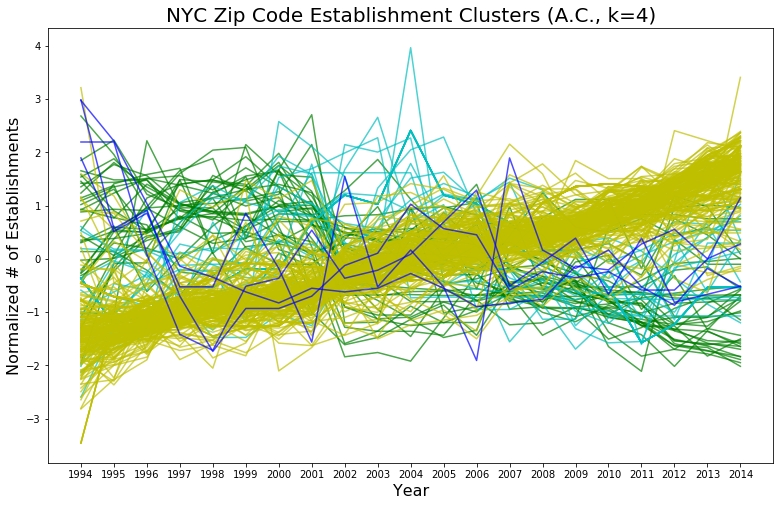

In [352]:
nc = 4
agc = AgglomerativeClustering(n_clusters=nc, linkage='average').fit(vals)
labelsag = agc.labels_
centroidsag = np.zeros((nc, vals.shape[1]))
colors = ['g','c','y','b']
plt.figure(figsize=(13, 8))
x = vals.columns
for u in unique(labelsag):
    for z in vals[labelsag==u].index:
        y = vals[vals.index == z].values.T
        plt.plot(x,y, color=colors[u], alpha = 0.7)
    print('Number of zip codes in %s line cluster: %i'%(colors[u],len(vals[labelsag==u])))
print('(g: green ; c: cyan ; y: yellow ; b: blue)')

plt.xlabel('Year', fontsize = 16)
plt.ylabel('Normalized # of Establishments', fontsize = 16)
plt.title('NYC Zip Code Establishment Clusters (A.C., k=4)', fontsize = 20)


**Figure 7:** The NYC establishment time series clustered using Agglomerative Clustering for 4 clusters. The trends are similar to the K-means method, however the blue line in this method shows more erratic (jagged) behavior, while the other 3 clusters are very similar to each other. 

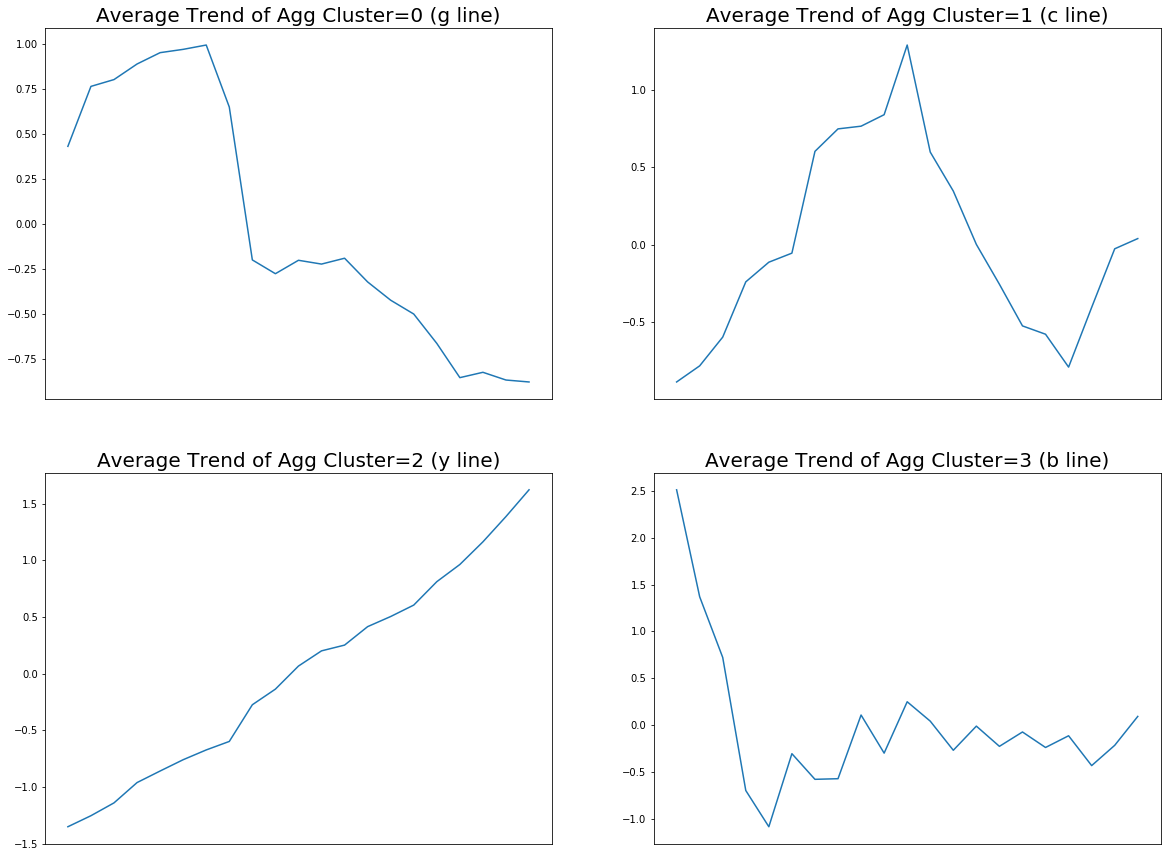

In [351]:
fig=plt.figure(figsize=(20,15))
for u in unique(labelsag):
    plt.subplot(2,2,u+1)
    plt.plot(vals[labelsag== u].mean(axis=0), '-')
    plt.xticks([])
    plt.title('Average Trend of Agg Cluster=%s (%s line)'%(u,colors[u]),size=20)

**Figure 8:** The average trend for the 4 clusters obtained using the agglomerative clustering technique are shown above for the period of time between 1996 and 2014. The trend for the green cluster plotted in Figure 7 shows an initial increase and then a sharp decline around the year 1999. The cyan cluster shows a peak around the year 2004. The yellow cluster is a increasing trend, while the blue line shows a sharp decline then a jagged line with clear periodicity. This blue line is interesting. 

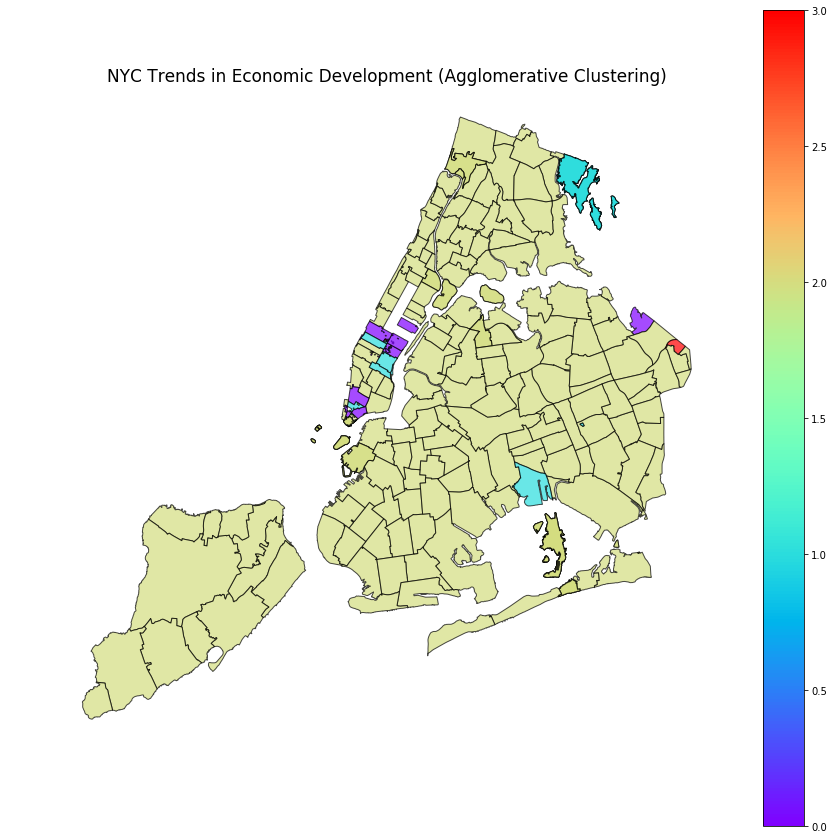

In [355]:
df['labelsag'] = labelsag
merged = nyczipsshp.merge(df, on='ZIPCODE')
f, ax = plt.subplots(1,figsize=(15,15))
ax.set_axis_off()
ax.set_title('NYC Trends in Economic Development (Agglomerative Clustering)',size=17)
merged.plot(ax=ax, column='labelsag', cmap='rainbow', k=4, edgecolor='k',legend=True, alpha=0.7)


**Figure 9**